In [1]:
%%capture capt
!pip install scikit-learn-extra
!pip install jellyfish

In [40]:
%%capture capt
import numpy as np
from sklearn_extra.cluster import KMedoids
from jellyfish import jaro_winkler_similarity
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import silhouette_score
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# Importation data

In [3]:
base_patient = pd.read_csv("../data/profil_patient.csv")

In [4]:
%%capture capt
p_soins = pd.read_csv("../data/parcours_soins.csv")

In [5]:
p_soins.head(3)

,BEN_NIR_IDT,2008-01-15,2008-02-15,2008-03-15,2008-04-15,2008-05-15,2008-06-15,2008-07-15,2008-08-15,2008-09-15,...,2018-12-19,2018-12-20,2018-12-21,2018-12-22,2018-12-24,2018-12-25,2018-12-26,2018-12-27,2018-12-28,2018-12-29
0,P0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
base_patient.head(3)

,CODE_PATIENT,date_h0,y_nais,BEN_RES_DPT,BEN_SEX_COD,dte_deces,Mort,Nb_survie,Nb_hospit,CHOC,Nb_jours_sej,cat_age,cat_nb_hospit,cat_nb_jours_sej,cluster
0,P0,2011-11-22,1949,11,1,NaN,False,2596,9,False,23,1,1,1,0
1,P6,2013-12-05,1929,14,2,2015-03,True,456,8,False,51,2,1,1,1
2,P8,2015-07-02,1967,54,2,2015-08,True,41,3,True,43,0,1,1,2


# Data Pre-processing

In [7]:
base_patient.Mort = base_patient.Mort.astype(int)
base_patient.CHOC = base_patient.CHOC.astype(int)
base_patient.BEN_SEX_COD = base_patient.BEN_SEX_COD-1

In [8]:
# on ne conserve que l'annee de la premiere hospitalisation

base_patient.date_h0 = pd.to_datetime(base_patient.date_h0).apply(lambda date: int(date.year))

# Lister tous les GHM

In [9]:
all_ghm = set()
for i in range(len(p_soins)):
    ghm_row = set(p_soins.iloc[i].dropna().tolist()[1:])
    all_ghm = all_ghm.union(ghm_row)   

In [10]:
nb_ghm = len(all_ghm)
print(nb_ghm)

2346


##### On fait un One-Hot Encoding de chaque GHM, qu'on stocke dans un dictionnaire

In [11]:
encoding_ghm = dict()
encoding_ghm[''] = encoding = [0]*nb_ghm
cur_index_to_encode_ghm = 0
for ghm in all_ghm:
    if encoding_ghm.get(ghm) != None:
        pass #le ghm a deja ete encode
    else:
        encoding = [0]*nb_ghm
        encoding[cur_index_to_encode_ghm] = 1
        cur_index_to_encode_ghm+=1
        encoding_ghm[ghm] = encoding

In [11]:
# on verifie que l'encodage a ete bien fait
# i.e on verifie que chaque ghm a bien un encodage unique
# si la boucle ne print rien, c'est que l'encodage ne presente pas de probleme
cur_ghm = -1
for ghm in encoding_ghm.keys():
    if np.argmax(encoding_ghm[ghm]) != cur_ghm:
        print(ghm)
    cur_ghm += 1

In [12]:
ghm_patient_encoded = []
for i in tqdm(range(len(base_patient))):
    ghm_row = p_soins.iloc[i].dropna().tolist()[1:]
    encoding_ghm_row = []
    for ghm in ghm_row:
        encoded_ghm = encoding_ghm[ghm]
        encoding_ghm_row.append(encoded_ghm)
    ghm_patient_encoded.append(encoding_ghm_row)

100%|██████████| 10051/10051 [00:03<00:00, 2747.11it/s]


In [13]:
max_len = 0
for p_soins_encoded in ghm_patient_encoded:
    max_len = max(max_len, len(p_soins_encoded))
    
print(max_len)

254


In [14]:
for i in range(len(ghm_patient_encoded)):
    while len(ghm_patient_encoded[i]) < max_len:
        ghm_patient_encoded[i].append(encoding_ghm[''])

### Encoding des patients

In [10]:
items_to_keep = ["date_h0", "y_nais", "BEN_SEX_COD", "Mort", "Nb_survie", "Nb_hospit", "CHOC"]

In [11]:
patient = base_patient[items_to_keep]

In [17]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [18]:
X_patient = []
for i in tqdm(range(len(patient))):
    row_patient = list(patient.iloc[i])
    ghm_patient = flatten(ghm_patient_encoded[i])
    X_patient_i = row_patient + ghm_patient
    X_patient.append(X_patient_i)

100%|██████████| 10051/10051 [03:43<00:00, 44.97it/s]


One-Hot Encoding est trop lourd: pouir chaque patient, on a un vecteur de dimension 254 x 2346 = 595,884 pour encoder les GHM

# Vecteur des parcours de GHM

In [12]:
X_patient = []
for i in range(len(base_patient)):
    ghm_row = p_soins.iloc[i].dropna().tolist()[1:]
    X_patient.append(ghm_row)

# Formules de distance entre string

In [13]:
def string_distance(s1, s2):
    # Compute distance between strings using the jaro winkler similarity formula
    return 1 - jaro_winkler_similarity(s1, s2)

def convert_to_sentence(arr):
    sentence = ''
    for x in arr:
        sentence += x + ","
    return sentence[:-1]

def jaro_winkler_distance(arr1, arr2):
    s1 = convert_to_sentence(arr1)
    s2 = convert_to_sentence(arr2)
    return abs(string_distance(s1, s2))

In [20]:
def custom_pairwise_distances(data, show=False):
    distances = []
    
    if not show:
        for i in range(len(data)):
            distance_i = []
            for j in range(len(data)):
                distance_i_j = jaro_winkler_distance(data[i], data[j])
                distance_i.append(distance_i_j)
            distances.append(distance_i)
        return np.array(distances)
            
    for i in tqdm(range(len(data))):
        distance_i = []
        for j in range(len(data)):
            distance_i_j = jaro_winkler_distance(data[i], data[j])
            distance_i.append(distance_i_j)
        distances.append(distance_i)
            
    return np.array(distances)

##### Un exemple de clustering K-Medoids pour voir comment ca marche

In [22]:
# List of strings
strings = [
    ["butterfly", "dragonfly", "ladybug", "grasshopper", "caterpillar", "bumblebee", "ant", "firefly", "beetle", "mosquito"],
    ["piano", "violin", "cello", "trumpet", "guitar", "drums", "saxophone", "clarinet", "flute", "harmonica"],
    ["pizza", "hamburger", "hotdog", "taco", "sushi", "ramen", "spaghetti", "steak", "burrito", "fajita"],
    ["ocean", "river", "lake", "waterfall", "stream", "pond", "rapids", "canal", "fjord", "delta"],
    ["book", "newspaper", "magazine", "novel", "comic", "journal", "catalog", "encyclopedia", "dictionary", "almanac"]
]

# Compute pairwise distances between strings using the custom distance metric
distances = custom_pairwise_distances(strings)

# Cluster strings using K-Medoids with 2 clusters
kmedoids = KMedoids(n_clusters=5, metric='precomputed', random_state=0)
clusters = kmedoids.fit_predict(distances)

# Print cluster assignments
for i, cluster in enumerate(clusters):
    print(f'String {i}: Cluster {cluster}')

String 0: Cluster 0
String 1: Cluster 1
String 2: Cluster 4
String 3: Cluster 3
String 4: Cluster 2


# K-Medoids sur les parcours de soins

### Calculate the custom pairwise distances

In [26]:
distances = custom_pairwise_distances(X_patient, show=True)

100%|██████████| 10051/10051 [13:31<00:00, 12.39it/s]


## Determiner le nombre de clusters

#### Regle du coude pour déterminer le nombre optimal de clusters

In [31]:
inertia=[]
nb_clusters_max = int(np.sqrt(len(base_patient)))

for n_clusters in tqdm(range(2, nb_clusters_max)):
    kmedoids = KMedoids(n_clusters=n_clusters, metric='precomputed')
    kmedoids.fit(distances)
    
    inertia.append(kmedoids.inertia_)

100%|██████████| 98/98 [01:01<00:00,  1.59it/s]


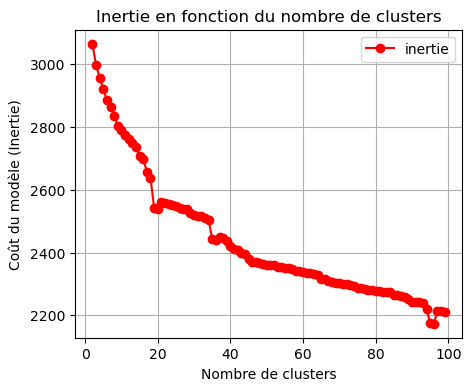

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(range(2, len(inertia)+2), inertia, c = 'r', label = 'inertie', marker='o')
ax.legend(loc='best')
ax.grid('on')
ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Coût du modèle (Inertie)')
ax.set_title('Inertie en fonction du nombre de clusters')
plt.show()

In [33]:
%%capture capt
!pip install kneed[plot]

from kneed import KneeLocator

k_elbow = KneeLocator(
  x=range(2, nb_clusters_max), 
  y=inertia, 
  curve="convex", 
  direction="decreasing").elbow

In [34]:
print(f"La méthode du coude nous indique que le nombre de clusters a faire = {k_elbow}")

La méthode du coude nous indique que le nombre de clusters a faire = 19


### BIC et Silhouette Scores

D'après ce papier: https://arxiv.org/abs/2212.12189 </br>
et ce code (https://github.com/smazzanti/are_you_still_using_elbow_method/blob/main/are-you-still-using-elbow-method.ipynb) qui compare plusieurs méthodes (Coude, Silhouette, Davies-Bouldin, Calinski-Harabasz, BIC), </br>
utiliser la méthode du coude n'est pas la meilleure option; il faut plutôt chercher à maximiser le score BIC, ou maximiser la silhouette (BIC donne des résultats très légèrement meilleurs). 

Tout est résumé ici: https://towardsdatascience.com/are-you-still-using-the-elbow-method-5d271b3063bd

In [35]:
import warnings
warnings.simplefilter("ignore")

In [36]:
def bic_score(X, labels):

    n_points = len(labels)
    n_clusters = len(set(labels))
    n_dimensions = np.shape(X)[1]

    n_parameters = (n_clusters - 1) + (n_dimensions * n_clusters) + 1

    loglikelihood = 0
    for label_name in set(labels):
        X_cluster = X[labels == label_name]
        n_points_cluster = len(X_cluster)
        centroid = np.mean(X_cluster, axis=0)
        variance = np.sum((X_cluster - centroid) ** 2) / (len(X_cluster) - 1)
        loglikelihood += \
          n_points_cluster * np.log(n_points_cluster) \
          - n_points_cluster * np.log(n_points) \
          - n_points_cluster * n_dimensions / 2 * np.log(2 * np.pi * variance) \
          - (n_points_cluster - 1) / 2

        bic = loglikelihood - (n_parameters / 2) * np.log(n_points)

    return bic

In [ ]:

    
    inertia.append(kmedoids.inertia_)

In [41]:
bic_scores = []
silhouette_scores = []
nb_clusters_max = int(np.sqrt(len(base_patient)))

for n_clusters in tqdm(range(2, nb_clusters_max)):
    kmedoids = KMedoids(n_clusters=n_clusters, metric='precomputed')
    kmedoids.fit(distances)
    
    try:
        bic = bic_score(distances, kmedoids.labels_)
        bic_scores.append(bic)
    except:
        bic_scores.append(-float('inf'))
        
    silhouette = silhouette_score(distances, kmedoids.labels_)
    silhouette_scores.append(silhouette)

100%|██████████| 98/98 [10:58<00:00,  6.72s/it]


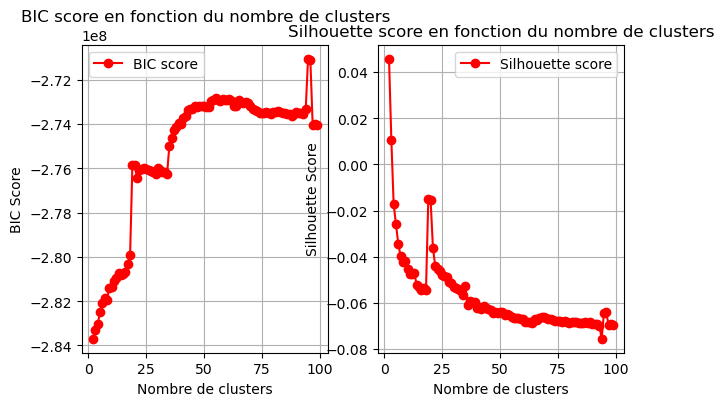

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(7, 4))

#plot bic score
ax[0].plot(range(2, len(bic_scores)+2), bic_scores, c = 'r', label = 'BIC score', marker='o')
ax[0].legend(loc='best')
ax[0].grid('on')
ax[0].set_xlabel('Nombre de clusters')
ax[0].set_ylabel('BIC Score')
ax[0].set_title('BIC score en fonction du nombre de clusters')

#plot silhouette scores
ax[1].plot(range(2, len(silhouette_scores)+2), silhouette_scores, c = 'r', label = 'Silhouette score', marker='o')
ax[1].legend(loc='best')
ax[1].grid('on')
ax[1].set_xlabel('Nombre de clusters')
ax[1].set_ylabel('Silhouette Score')
ax[1].set_title('Silhouette score en fonction du nombre de clusters')

plt.show()